In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import (
    StandardScaler, label_binarize, PolynomialFeatures,
    RobustScaler, robust_scale, quantile_transform, QuantileTransformer)
from sklearn.compose import make_column_selector, ColumnTransformer
from scipy.stats.mstats import winsorize
from sklearn.calibration import CalibratedClassifierCV
import xgboost
from joblib import dump, load
np.random.seed(0)  # make sure results are reproducible

In [2]:
%env PATH=/home/jdkent/.conda/envs/comfy_pants/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/conda/bin


env: PATH=/home/jdkent/.conda/envs/comfy_pants/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/conda/bin


In [3]:
TRAINING_DATA_PATH = '../data/BipolarDerivedDataTraining.csv'
TESTING_DATA_PATH = '../data/BipolarDerivedDataTesting.csv'
NTHREADS = 32

In [4]:
training_X = pd.read_csv(TRAINING_DATA_PATH)
training_y = label_binarize(pd.read_csv(TRAINING_DATA_PATH)['group'], classes=["Case", "Control"]).squeeze()
testing_X = pd.read_csv(TESTING_DATA_PATH)

In [5]:
missing_cols = [
    'ses_ladder_rung',
    'history_smoking', 'frequency_currentsmoking',
    'age_at_first_mood_syndrome', 'madrs_score', 'ymrs_score',
    'suicideideation_rating_mostsevere_life',
    'suicideideation_rating_mostsevere_1month',
    'suicideattempts_lifetimenumber'
]
missing_cols.reverse()
for col in missing_cols:
    testing_X.insert(4, col, ["NOT REAL"] * testing_X.shape[0])
testing_X.insert(1, "group", ["NOT REAL"] * testing_X.shape[0])
testing_X.rename(columns={"Age": "age", "Sex": "gender", 'Hand': 'handedness'}, inplace=True)

In [6]:
set(training_X.columns) - set(testing_X.columns)

set()

In [7]:
training_X.columns[:17]

Index(['record_id', 'group', 'age', 'gender', 'handedness', 'ses_ladder_rung',
       'history_smoking', 'frequency_currentsmoking',
       'age_at_first_mood_syndrome', 'madrs_score', 'ymrs_score',
       'suicideideation_rating_mostsevere_life',
       'suicideideation_rating_mostsevere_1month',
       'suicideattempts_lifetimenumber', 'allvol_unknown',
       'allvol_ctx_rh_posterior_insula', 'allvol_ctx_lh_posterior_insula'],
      dtype='object')

In [8]:
testing_X.columns[:17]

Index(['record_id', 'group', 'age', 'gender', 'handedness', 'ses_ladder_rung',
       'history_smoking', 'frequency_currentsmoking',
       'age_at_first_mood_syndrome', 'madrs_score', 'ymrs_score',
       'suicideideation_rating_mostsevere_life',
       'suicideideation_rating_mostsevere_1month',
       'suicideattempts_lifetimenumber', 'allvol_unknown',
       'allvol_ctx_rh_posterior_insula', 'allvol_ctx_lh_posterior_insula'],
      dtype='object')

## Model 1 (XGBoost with feature selection)

In [321]:
# supposedly ideal "scale_pos_weight"
best_spw = (training_y == 0).sum() / training_y.sum()
best_spw

1.8387096774193548

In [9]:
np.random.seed(0) 
MODEL1 = '../models/model1-jdkent.joblib'
OVERWRITE_MODEL1 = False
if not os.path.isfile(MODEL1) or OVERWRITE_MODEL1:
    os.remove(MODEL1)
    select_data = ColumnTransformer(
        [(
            "select_features",
            "passthrough", 
            make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
        remainder='drop'
    )

    fix_outliers = QuantileTransformer(output_distribution='normal')

    imputer = IterativeImputer(add_indicator=False,
                               initial_strategy='median',
                               imputation_order='random',
                               sample_posterior=True,
                               max_iter=50,
                               n_nearest_features=50,
                               random_state=42)

    scaler = StandardScaler()
    kbest = SelectKBest(k=1000)
    pca = PCA(n_components=40, whiten=True)
    select_pca = SelectKBest(k=5)
    clf = xgboost.XGBClassifier(
        n_estimators=2500, subsample=0.8, learning_rate=0.001,
        max_depth=5, scale_pos_weight=3)


    pipeline1 = Pipeline([("data", select_data),
                          ("outlier", fix_outliers),
                          ("imp", imputer),
                          ("scaler", scaler),
                          ("kbest", kbest),
                          ("pca", pca),
                          ("select", select_pca),
                          ("clf", clf)])
    pipeline1.fit(training_X, training_y)
    # write model to file
    dump(pipeline1, MODEL1)
else:
    pipeline1 = load(MODEL1)

prediction1 = pipeline1.predict(testing_X)
prediction1

/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1])

In [10]:
# intuition on whether the model is split approx 50/50
display((prediction1 == 1).sum())
display((prediction1 == 0).sum())

20

19

## Model 2 (Logistic Regression with feature selection)

In [13]:
np.random.seed(0)
MODEL2 = '../models/model2-jdkent.joblib'
OVERWRITE_MODEL2 = False
if not os.path.isfile(MODEL2) or OVERWRITE_MODEL2:
    os.remove(MODEL2)
    select_data = ColumnTransformer(
        [(
            "select_features",
            "passthrough", 
            make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
        remainder='drop'
    )

    fix_outliers = QuantileTransformer(output_distribution='normal')

    imputer = IterativeImputer(add_indicator=False,
                               initial_strategy='median',
                               imputation_order='random',
                               sample_posterior=True,
                               max_iter=50,
                               n_nearest_features=50,
                               random_state=42)

    scaler = StandardScaler()
    kbest = SelectKBest(k=1000)
    pca = PCA(n_components=40, whiten=True)
    selector = LogisticRegression(C=1000, class_weight={0: 1, 1: 3}, random_state=42, max_iter=10000)

    rfe = RFE(selector, n_features_to_select=10)

    clf = LogisticRegression(C=1000, class_weight={0: 1, 1: 3}, random_state=42, max_iter=10000)

    pipeline2 = Pipeline([("data", select_data),
                          ("outliers", fix_outliers),
                          ("imp", imputer),
                          ("scaler", scaler),
                          ("kbest", kbest),
                          ("pca", pca),
                          ("rfe", rfe),
                          ("clf", clf)])
    pipeline2.fit(training_X, training_y)
    # write model to file
    dump(pipeline2, MODEL2)
else:
    pipeline2 = load(MODEL2)

prediction2 = pipeline2.predict(testing_X)
prediction2

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0])

In [14]:
display((prediction2 == 1).sum())
display((prediction2 == 0).sum())

20

19

25

In [20]:
estimators = [("model1", pipeline1), ("model2", pipeline2)]
vote = VotingClassifier(estimators, voting='soft')
vote.fit(training_X, training_y)
all_predict = vote.predict(testing_X)
all_predict

/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0])

In [22]:
display((all_predict == 1).sum())
display((all_predict == 0).sum())

20

19

In [446]:
(all_predict == prediction1).sum()

31

In [447]:
(all_predict == prediction2).sum()

33

## Investigate data dimensionality

In [159]:
select_data = ColumnTransformer(
    [(
        "select_features",
        "passthrough", 
        make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
    remainder='drop'
)

fix_outliers = QuantileTransformer(output_distribution='normal')

imputer = IterativeImputer(add_indicator=False,
                           initial_strategy='median',
                           imputation_order='random',
                           sample_posterior=True,
                           max_iter=10,
                           n_nearest_features=50,
                           random_state=42)

scaler = StandardScaler()
kbest = SelectKBest(k=1000)
pca = PCA()

pipeline_pca = Pipeline([("data", select_data),
                      ("outliers", fix_outliers),
                      ("imp", imputer),
                      ("scaler", scaler),
                      ("kbest", kbest),
                      ("pca", pca)])

pca_res = pipeline_pca.fit_transform(training_X, training_y)


/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [160]:
pca_keep = pca_res[:,:-1]

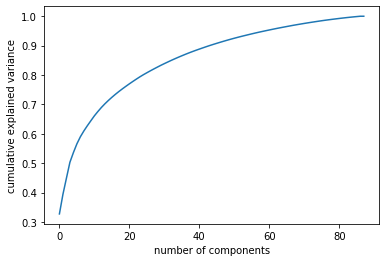

In [161]:
plt.plot(np.cumsum(pipeline_pca.named_steps['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [162]:
kbest_pca = SelectKBest(k="all")
kbest_pca.fit(pca_keep, training_y)

SelectKBest(k='all', score_func=<function f_classif at 0x7f8f05d4edd0>)

<BarContainer object of 87 artists>

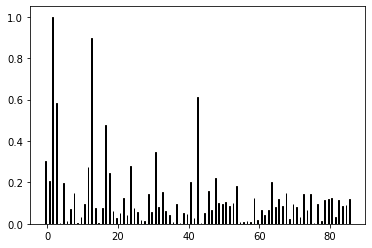

In [163]:
# indices
X_indices = np.arange(pca_keep.shape[-1] )
scores = -np.log10(kbest_pca.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [165]:
# get the two best components
kbest_pca.k = 2
best_components = kbest_pca.fit_transform(pca_keep, training_y)

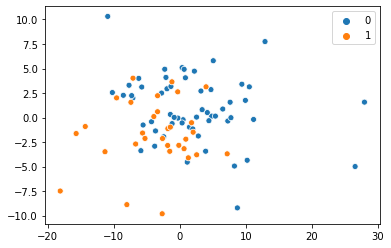

In [171]:
sns.scatterplot(x=best_components[:,0], y=best_components[:,1], hue=training_y)

In [178]:
indices = kbest_pca.get_support(indices=True)

In [246]:
loadings = pipeline_pca.named_steps['pca'].components_[indices,:]

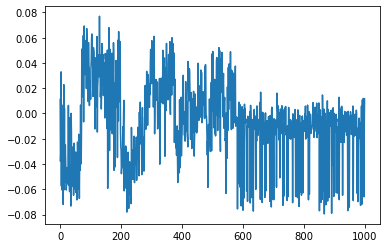

In [279]:
sns.lineplot(x=np.arange(loadings.shape[1]), y=loadings[0,:])

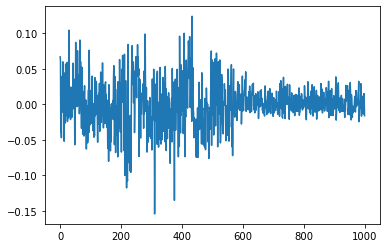

In [280]:
sns.lineplot(x=np.arange(loadings.shape[1]), y=loadings[1,:])

In [249]:
dset_idxs = pipeline_pca.named_steps['kbest'].get_support(indices=True)
columns = training_X.columns[dset_idxs]

In [281]:
# grab top 10 features loaded
comp0_top = np.argpartition(np.abs(loadings[0,:]), -15)[-10:]
# organize the features
comp0_top = comp0_top[np.argsort(np.abs(loadings[0,:])[comp0_top])]

In [282]:
# grab top 10 features loaded
comp1_top = np.argpartition(np.abs(loadings[1,:]), -15)[-10:]
# organize the features
comp1_top = comp1_top[np.argsort(np.abs(loadings[1,:])[comp1_top])]

In [283]:
columns[comp0_top]

Index(['allvol_wm_rh_supramarginal', '31p_r_wm_frontpole_ph',
       '31p_crbl_verm_viii_x_ph', 'alff_ctxristhcing_m',
       '31p_l_rosmidfront_ph', '31p_l_wm_crbl_ph', '31p_l_wm_caudmfg_ph',
       't1r_ctxrcdlantcing_m', '31p_r_opifg_ph', '31p_l_ofug_ph'],
      dtype='object')

In [284]:
columns[comp1_top]

Index(['dti_r_sup_fofas_fa', 'alff_ctxlinfparie_m', 'dti_l_ant_corrad_km',
       'alff_ctxlrostmidfrnt_m', 'allvol_wm_rh_entorhinal', 'alff_lsupfront_m',
       'alff_ctxlprecuneus_m', 'dti_r_cing_gyrus_kax', 'dti_r_sup_fofas_rd',
       'dti_r_sup_fofas_md'],
      dtype='object')

## Investigate Model2

### Select Data

In [355]:
x_features = training_X.loc[:,pipeline2.named_steps['data'].transformers_[0][2]]
x_features.shape

(88, 1770)

### Fix Outliers

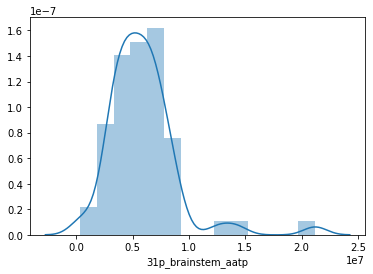

In [356]:
sns.distplot(x_features['31p_brainstem_aatp'])
col_idx = x_features.columns.get_loc('31p_brainstem_aatp')

In [357]:
x_features_quantrans = pipeline2.named_steps['outliers'].transform(x_features)

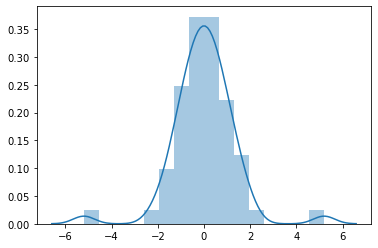

In [358]:
# plot post transformation ...
sns.distplot(x_features_quantrans[:,col_idx])

### Imputation

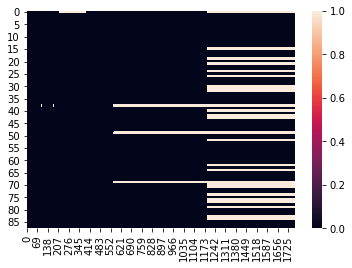

In [359]:
sns.heatmap(np.isnan(x_features_quantrans))

In [360]:
x_features_impute = pipeline2.named_steps['imp'].transform(x_features_quantrans)

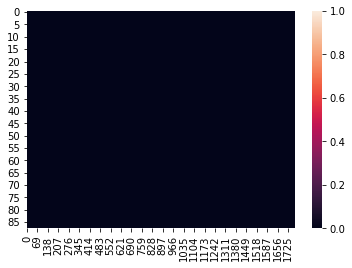

In [361]:
sns.heatmap(np.isnan(x_features_impute), vmin=0, vmax=1)

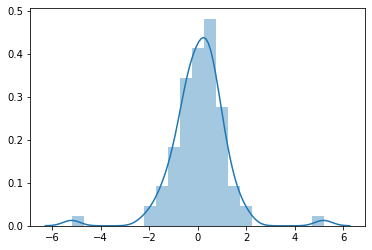

In [362]:
sns.distplot(x_features_impute[:,col_idx])

### Standardize

In [363]:
x_features_standard = pipeline2.named_steps['scaler'].transform(x_features_impute)

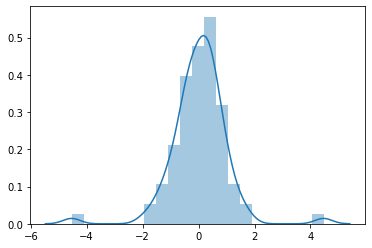

In [364]:
sns.distplot(x_features_standard[:,col_idx])

In [365]:
percent_diff = ((x_features_standard[:,col_idx] - x_features_impute[:,col_idx]) / x_features_impute[:,col_idx]) * 100

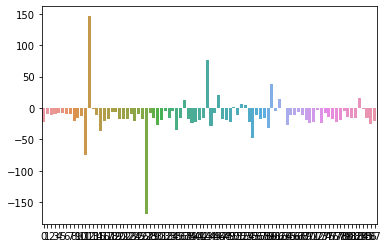

In [366]:
# changes in value for each participant as a result of standarizing
sns.barplot(x=np.arange(88), y=percent_diff)

### KBest (select 1000 most discriminating features)

In [367]:
best_1000_idx = pipeline2.named_steps['kbest'].get_support()
x_features_1000 = x_features_standard[:,best_1000_idx]
x_features_1000.shape

(88, 1000)

In [368]:
columns_1000 = x_features.columns[best_1000_idx]

In [369]:
modalities = ['allvol', 'alff', 't1r', 'dti', '31p']

modality_counts = {mod: [len(list(filter(lambda x: mod in x, columns_1000)))] for mod in modalities}
modality_counts

{'allvol': [71], 'alff': [59], 't1r': [121], 'dti': [282], '31p': [467]}

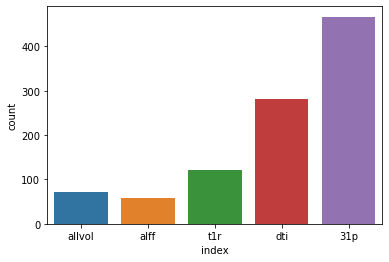

In [370]:
mod_df = pd.DataFrame.from_dict(modality_counts).T
mod_df.rename({0: 'count'}, axis=1, inplace=True)
sns.barplot(x='index', y='count', data=mod_df.reset_index())

### PCA

In [371]:
x_features_pca = pipeline2.named_steps['pca'].transform(x_features_1000)

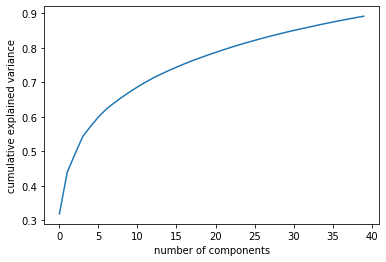

In [372]:
plt.plot(np.cumsum(pipeline2.named_steps['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Recursive Feature Elimination (select 10 best PCA components)

In [373]:
pca_idx = pipeline2.named_steps['rfe'].get_support()
x_features_pca[:,pca_idx].shape

(88, 10)

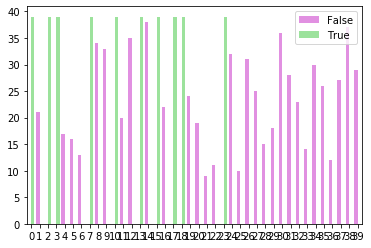

In [374]:
# look at which components were selected
colors = ['violet' if x else 'lightgreen' for x in pca_idx]
sns.barplot(x=np.arange(40), hue=pca_idx, y= 40 - pipeline2.named_steps['rfe'].ranking_, palette=colors)

In [375]:
x_features_best_pca = best_pca = x_features_pca[:,pca_idx]

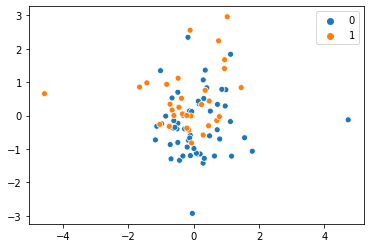

In [376]:
sns.scatterplot(x=best_pca[:,0], y=best_pca[:,1], hue=training_y)

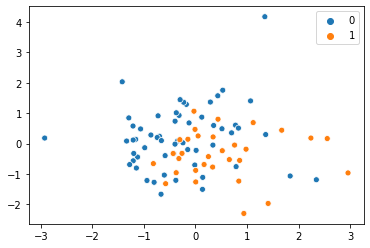

In [377]:
sns.scatterplot(x=best_pca[:,1], y=best_pca[:,2], hue=training_y)

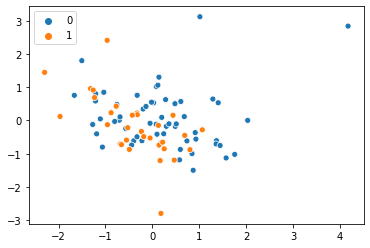

In [378]:
sns.scatterplot(x=best_pca[:,2], y=best_pca[:,3], hue=training_y)

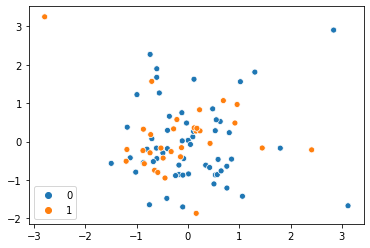

In [379]:
sns.scatterplot(x=best_pca[:,3], y=best_pca[:,4], hue=training_y)

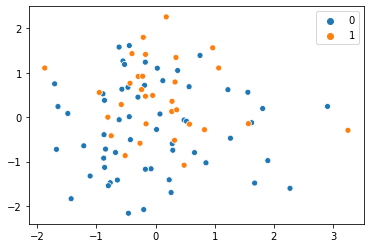

In [380]:
sns.scatterplot(x=best_pca[:,4], y=best_pca[:,5], hue=training_y)

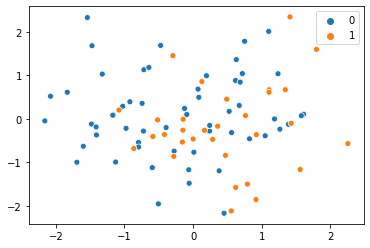

In [381]:
sns.scatterplot(x=best_pca[:,5], y=best_pca[:,6], hue=training_y)

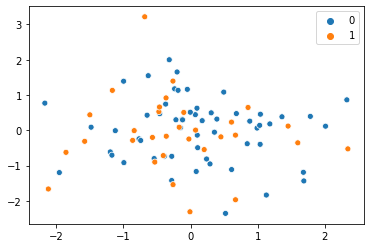

In [382]:
sns.scatterplot(x=best_pca[:,6], y=best_pca[:,7], hue=training_y)

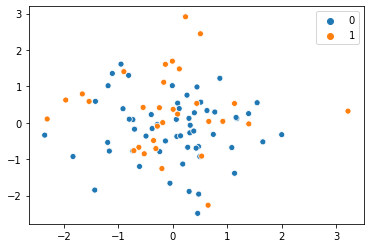

In [383]:
sns.scatterplot(x=best_pca[:,7], y=best_pca[:,8], hue=training_y)

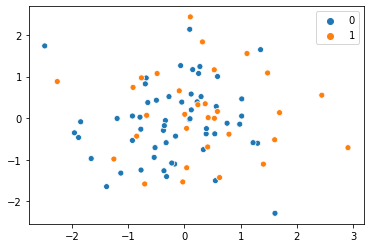

In [384]:
sns.scatterplot(x=best_pca[:,8], y=best_pca[:,9], hue=training_y)

In [385]:
loadings = pipeline2.named_steps['pca'].components_[pca_idx,:]

In [386]:
modality = [col.split('_')[0] for col in columns_1000]
loadings_df = pd.DataFrame(loadings.T)
loadings_df['modality'] = modality
loadings_df.rename({x: 'loading_{}'.format(x) for x in range(10)}, axis=1, inplace=True)
loadings_df.head()

,loading_0,loading_1,loading_2,loading_3,loading_4,loading_5,loading_6,loading_7,loading_8,loading_9,modality
0,-0.000565,0.009236,0.005285,0.127032,0.041497,-0.052653,-0.041129,-0.007932,-0.067647,0.058649,allvol
1,0.005096,-0.027143,-0.055756,0.056170,0.013297,-0.074350,-0.016070,0.004038,0.027098,-0.005165,allvol
2,0.003139,-0.038489,-0.049576,-0.020939,0.045031,0.043714,0.063865,-0.052636,-0.016653,0.031076,allvol
3,0.004259,-0.012782,0.036731,0.071234,0.082245,0.011439,0.003867,0.016738,0.010569,0.023867,allvol
4,0.006163,-0.021923,-0.077503,0.002277,0.024508,0.044865,-0.048548,-0.012970,0.013502,0.050165,allvol


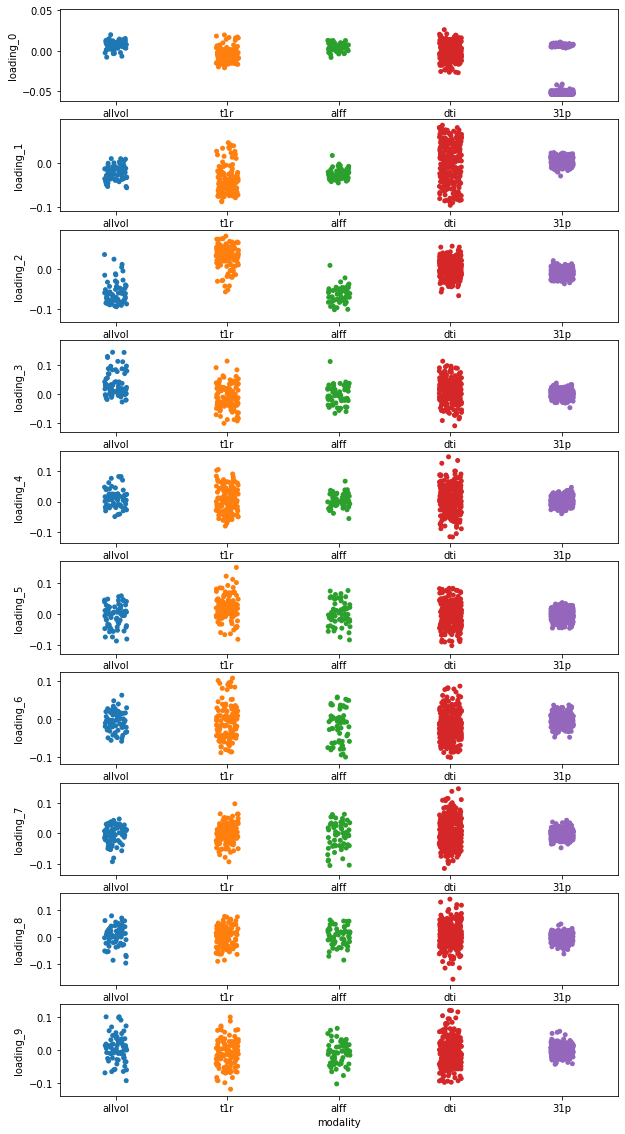

In [387]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))

for (idx, ax) in enumerate(axes):
    sns.stripplot(x='modality', y='loading_{}'.format(idx), data=loadings_df.reset_index(), hue='modality', ax=ax)
    ax.get_legend().remove()

In [388]:
# lets look at loading 1, for spectroscopy
index = loadings_df.query("(modality == '31p') & (loading_0 < -0.054) ")['loading_0'].index
index.shape

(19,)

In [389]:
best_pca_features_df = pd.DataFrame(x_features_best_pca)
best_pca_features_df['group'] = training_y
best_pca_features_df.rename({x: 'pca_{}'.format(x) for x in range(10)}, axis=1, inplace=True)
best_pca_features_df.head()


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,group
0,0.292018,1.068028,1.401312,0.532712,-0.871238,-0.393426,-0.200582,1.653385,-0.523204,-0.705419,0
1,0.965030,0.288530,1.364272,-0.607974,-0.443967,1.610240,0.105795,-0.494284,-0.364354,-1.261682,0
2,0.984092,0.776146,0.605303,0.570557,-0.863186,0.378997,-1.194846,-0.613327,-1.198339,-0.005698,0
3,1.128273,1.836820,-1.065090,-0.799724,-0.199965,-2.077913,0.520179,-2.356151,-0.338494,-0.054516,0
4,0.308797,0.513573,0.486826,-0.177623,-0.614976,-0.057544,-1.480613,0.087289,0.540324,-0.374218,0


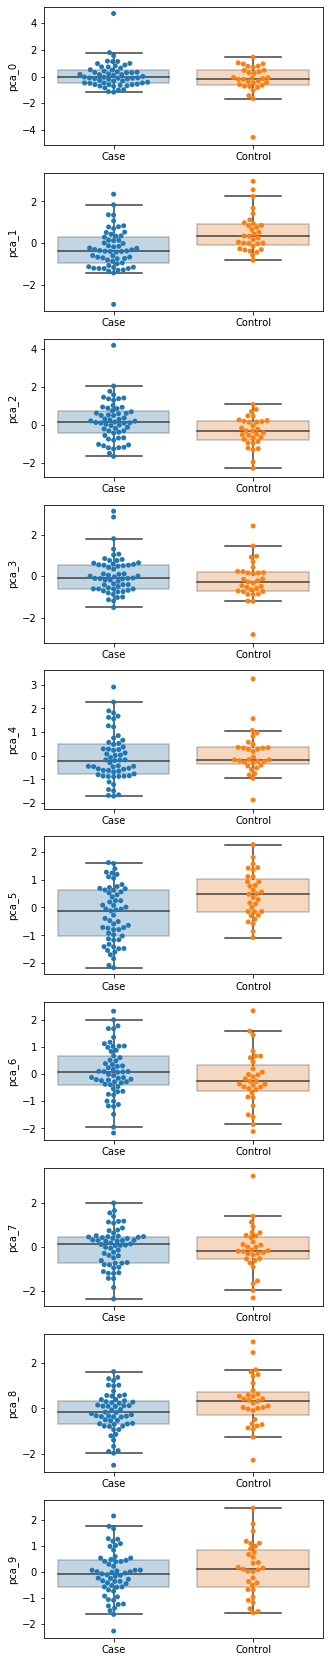

In [390]:
fig, axes = plt.subplots(nrows=10, figsize=(5, 30))

for idx, ax in enumerate(axes):
    sns.swarmplot(x='group', y='pca_{}'.format(idx), hue='group', ax=ax, data=best_pca_features_df)
    sns.boxplot(x='group', y='pca_{}'.format(idx), hue='group', ax=ax, data=best_pca_features_df,
                showfliers=False, dodge=False, boxprops=dict(alpha=.3))
    ax.get_legend().remove()
    ax.set_xticklabels(["Case", "Control"])
    ax.set_xlabel("")

In [391]:
list(columns_1000[index])

['31p_l_wm_supfront_aatp',
 '31p_r_precent_gatp',
 '31p_r_precent_aatp',
 '31p_r_smc_aatp',
 '31p_r_mfg_aatp',
 '31p_r_temppole_aatp',
 '31p_l_mfg_aatp',
 '31p_r_ocp_gatp',
 '31p_l_wm_suptemp_aatp',
 '31p_r_wm_postcent_aatp',
 '31p_r_crbl_cort_aatp',
 '31p_r_suppar_aatp',
 '31p_l_crblcrtx_gatp',
 '31p_l_wm_insula_aatp',
 '31p_r_postcent_gatp',
 '31p_r_wm_parcent_aatp',
 '31p_r_sfg_aatp',
 '31p_r_mog_aatp',
 '31p_r_wm_precent_aatp']

### Logistic Regression

In [392]:
from scipy.special import expit
pipeline2.named_steps['clf'].coef_

array([[-1.23483667,  2.53811006, -1.39940871, -1.41374364,  1.27034861,
         1.88076547, -0.98550745, -0.72363342,  0.75848958,  0.8082933 ]])

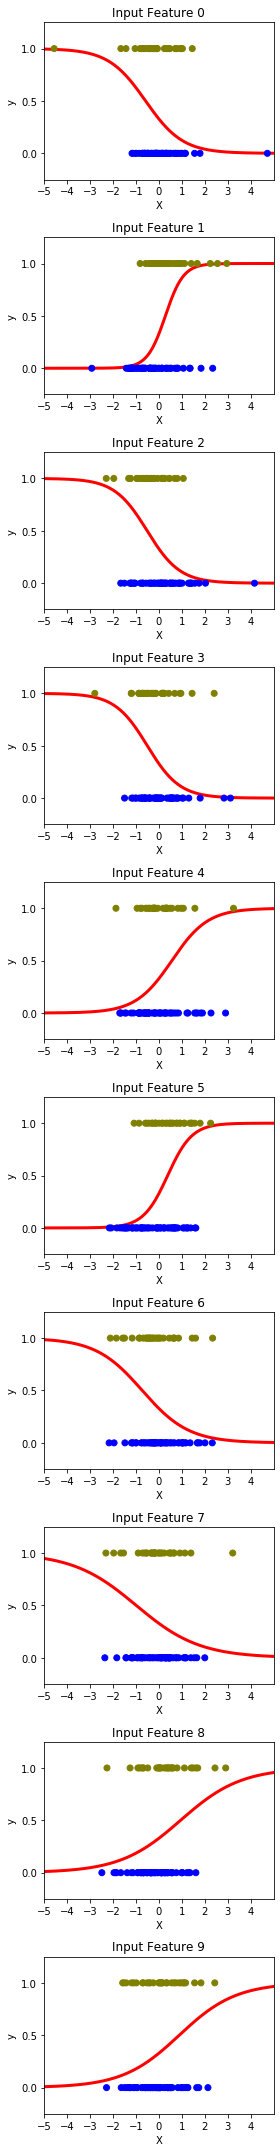

In [393]:
# and plot the result
colors = ['olive' if x == 1 else 'blue' for x in training_y]
fig, axes = plt.subplots(nrows=10, figsize=(4, 30))
for idx, ax in enumerate(axes):
    ax.scatter(x_features_best_pca[:,idx].ravel(), training_y, color=colors, zorder=20)
    X_test = np.linspace(-5, 5, 300)

    loss = expit(X_test * pipeline2.named_steps['clf'].coef_[0][idx] + pipeline2.named_steps['clf'].intercept_).ravel()
    ax.plot(X_test, loss, color='red', linewidth=3)


    ax.set_ylabel('y')
    ax.set_xlabel('X')
    ax.set_xticks(range(-5, 5))
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim(-.25, 1.25)
    ax.set_xlim(-5, 5)
    ax.set_title("Input Feature {}".format(idx))

fig.tight_layout()

## See what the test data looks like

### Select Data

In [396]:
x_features = testing_X.loc[:,pipeline2.named_steps['data'].transformers_[0][2]]
x_features.shape

(39, 1770)

### Fix Outliers

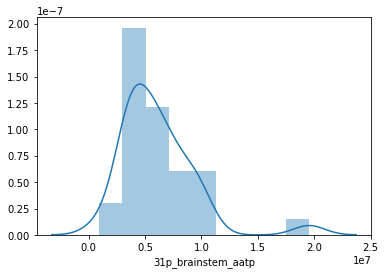

In [397]:
sns.distplot(x_features['31p_brainstem_aatp'])
col_idx = x_features.columns.get_loc('31p_brainstem_aatp')

In [398]:
x_features_quantrans = pipeline2.named_steps['outliers'].transform(x_features)

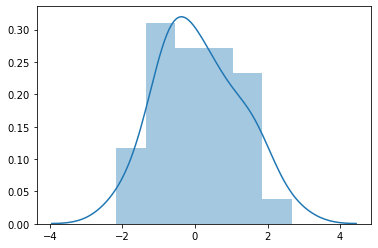

In [399]:
# plot post transformation ...
sns.distplot(x_features_quantrans[:,col_idx])

### Imputation

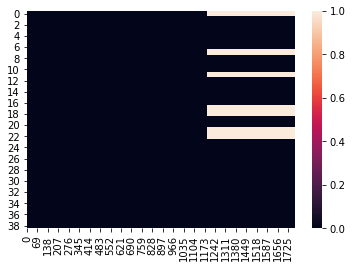

In [400]:
sns.heatmap(np.isnan(x_features_quantrans))

In [401]:
x_features_impute = pipeline2.named_steps['imp'].transform(x_features_quantrans)

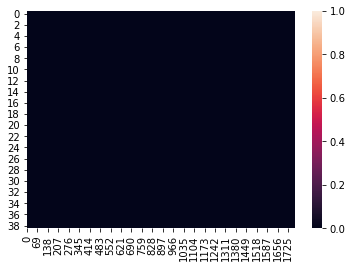

In [402]:
sns.heatmap(np.isnan(x_features_impute), vmin=0, vmax=1)

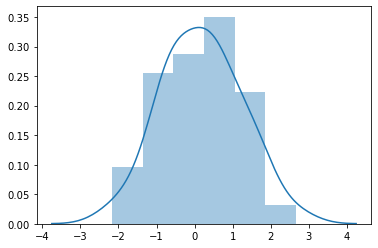

In [403]:
sns.distplot(x_features_impute[:,col_idx])

### Standardize

In [404]:
x_features_standard = pipeline2.named_steps['scaler'].transform(x_features_impute)

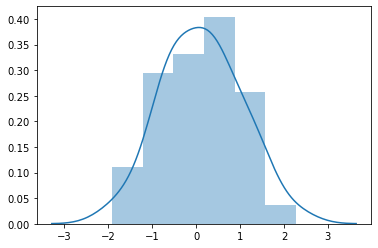

In [405]:
sns.distplot(x_features_standard[:,col_idx])

In [406]:
percent_diff = ((x_features_standard[:,col_idx] - x_features_impute[:,col_idx]) / x_features_impute[:,col_idx]) * 100

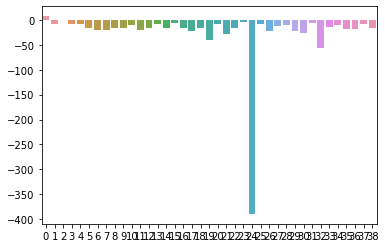

In [413]:
# changes in value for each participant as a result of standarizing
sns.barplot(x=np.arange(39), y=percent_diff)

### KBest (select 1000 most discriminating features)

In [414]:
best_1000_idx = pipeline2.named_steps['kbest'].get_support()
x_features_1000 = x_features_standard[:,best_1000_idx]
x_features_1000.shape

(39, 1000)

In [415]:
columns_1000 = x_features.columns[best_1000_idx]

In [416]:
modalities = ['allvol', 'alff', 't1r', 'dti', '31p']

modality_counts = {mod: [len(list(filter(lambda x: mod in x, columns_1000)))] for mod in modalities}
modality_counts

{'allvol': [71], 'alff': [59], 't1r': [121], 'dti': [282], '31p': [467]}

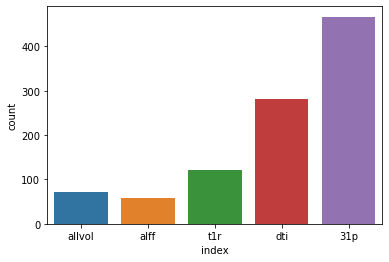

In [417]:
mod_df = pd.DataFrame.from_dict(modality_counts).T
mod_df.rename({0: 'count'}, axis=1, inplace=True)
sns.barplot(x='index', y='count', data=mod_df.reset_index())

### PCA

In [418]:
x_features_pca = pipeline2.named_steps['pca'].transform(x_features_1000)

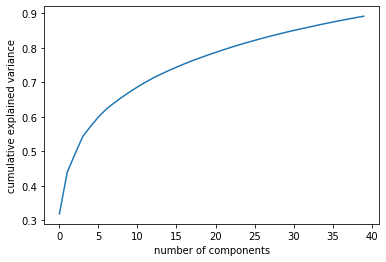

In [419]:
plt.plot(np.cumsum(pipeline2.named_steps['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Recursive Feature Elimination (select 10 best PCA components)

In [420]:
pca_idx = pipeline2.named_steps['rfe'].get_support()
x_features_pca[:,pca_idx].shape

(39, 10)

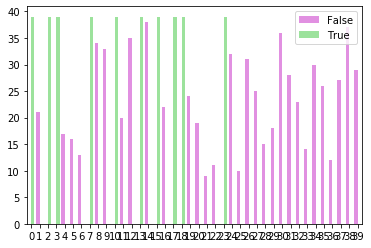

In [421]:
# look at which components were selected
colors = ['violet' if x else 'lightgreen' for x in pca_idx]
sns.barplot(x=np.arange(40), hue=pca_idx, y= 40 - pipeline2.named_steps['rfe'].ranking_, palette=colors)

In [422]:
x_features_best_pca = best_pca = x_features_pca[:,pca_idx]

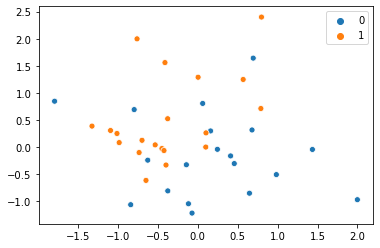

In [423]:
sns.scatterplot(x=best_pca[:,0], y=best_pca[:,1], hue=y_best_guess)

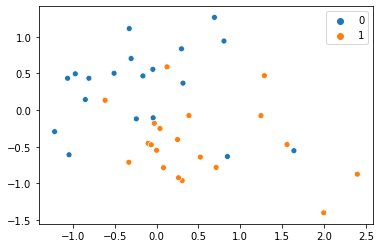

In [425]:
sns.scatterplot(x=best_pca[:,1], y=best_pca[:,2], hue=y_best_guess)

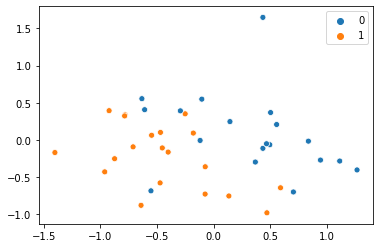

In [426]:
sns.scatterplot(x=best_pca[:,2], y=best_pca[:,3], hue=y_best_guess)

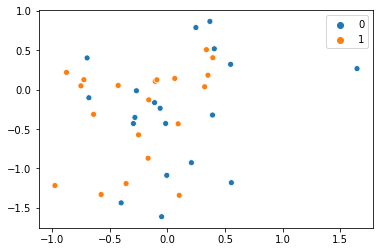

In [427]:
sns.scatterplot(x=best_pca[:,3], y=best_pca[:,4], hue=y_best_guess)

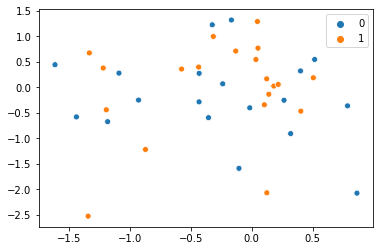

In [428]:
sns.scatterplot(x=best_pca[:,4], y=best_pca[:,5], hue=y_best_guess)

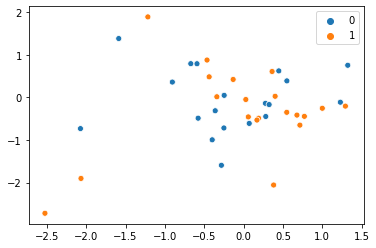

In [429]:
sns.scatterplot(x=best_pca[:,5], y=best_pca[:,6], hue=y_best_guess)

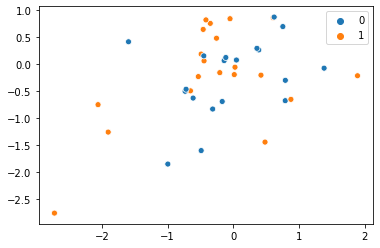

In [430]:
sns.scatterplot(x=best_pca[:,6], y=best_pca[:,7], hue=y_best_guess)

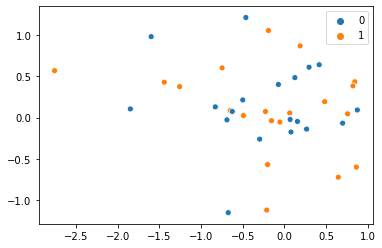

In [431]:
sns.scatterplot(x=best_pca[:,7], y=best_pca[:,8], hue=y_best_guess)

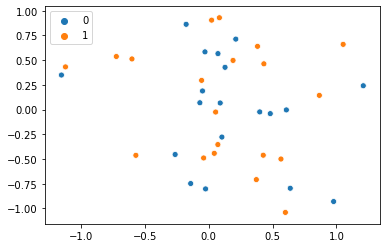

In [432]:
sns.scatterplot(x=best_pca[:,8], y=best_pca[:,9], hue=y_best_guess)

In [433]:
loadings = pipeline2.named_steps['pca'].components_[pca_idx,:]

In [434]:
modality = [col.split('_')[0] for col in columns_1000]
loadings_df = pd.DataFrame(loadings.T)
loadings_df['modality'] = modality
loadings_df.rename({x: 'loading_{}'.format(x) for x in range(10)}, axis=1, inplace=True)
loadings_df.head()

,loading_0,loading_1,loading_2,loading_3,loading_4,loading_5,loading_6,loading_7,loading_8,loading_9,modality
0,-0.000565,0.009236,0.005285,0.127032,0.041497,-0.052653,-0.041129,-0.007932,-0.067647,0.058649,allvol
1,0.005096,-0.027143,-0.055756,0.056170,0.013297,-0.074350,-0.016070,0.004038,0.027098,-0.005165,allvol
2,0.003139,-0.038489,-0.049576,-0.020939,0.045031,0.043714,0.063865,-0.052636,-0.016653,0.031076,allvol
3,0.004259,-0.012782,0.036731,0.071234,0.082245,0.011439,0.003867,0.016738,0.010569,0.023867,allvol
4,0.006163,-0.021923,-0.077503,0.002277,0.024508,0.044865,-0.048548,-0.012970,0.013502,0.050165,allvol


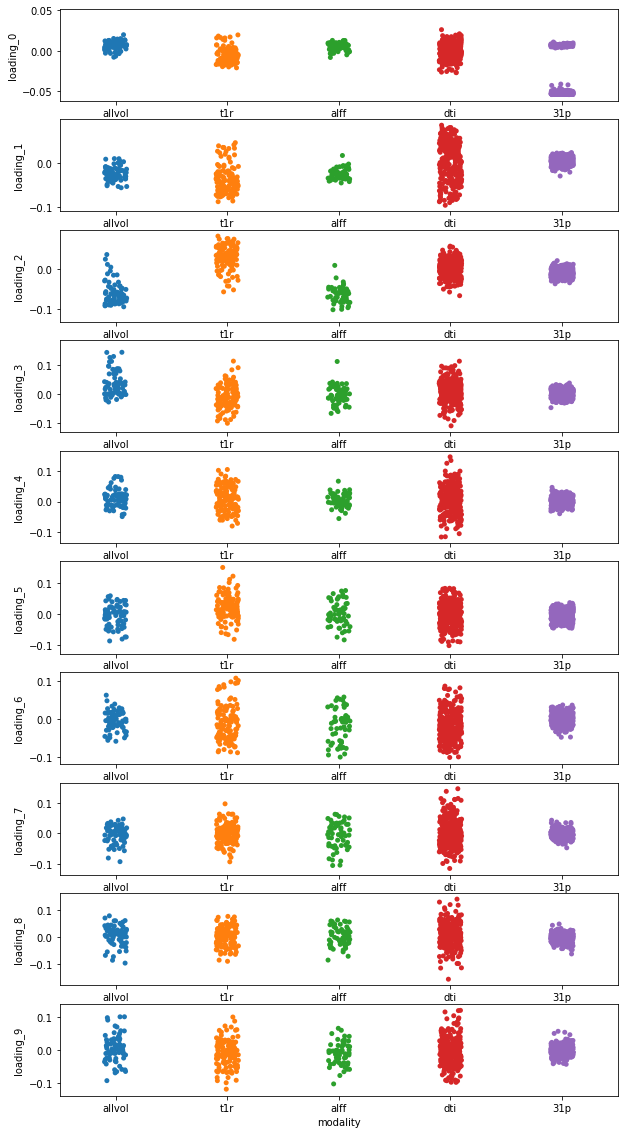

In [435]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))

for (idx, ax) in enumerate(axes):
    sns.stripplot(x='modality', y='loading_{}'.format(idx), data=loadings_df.reset_index(), hue='modality', ax=ax)
    ax.get_legend().remove()

In [436]:
# lets look at loading 1, for spectroscopy
index = loadings_df.query("(modality == '31p') & (loading_0 < -0.054) ")['loading_0'].index
index.shape

(19,)

In [438]:
best_pca_features_df = pd.DataFrame(x_features_best_pca)
best_pca_features_df['group'] = y_best_guess
best_pca_features_df.rename({x: 'pca_{}'.format(x) for x in range(10)}, axis=1, inplace=True)
best_pca_features_df.head()


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,group
0,0.160805,0.297907,0.834824,-0.015566,-0.430775,0.276957,-0.140636,0.069578,-0.023734,-0.802702,0
1,0.569064,1.247597,-0.076487,-0.726314,0.124063,-2.066136,-1.903654,-1.255065,0.373393,-0.708503,1
2,0.694974,1.641353,-0.554414,-0.682710,-0.104327,-1.586529,1.379384,-0.070878,0.399888,-0.023469,0
3,0.790756,0.712022,-0.782760,0.338563,0.504905,0.190197,-0.490151,0.190236,0.866475,0.143899,1
4,0.679804,0.316213,0.366728,-0.295992,-0.431443,-0.282439,-1.594913,0.418151,0.638853,-0.796052,0


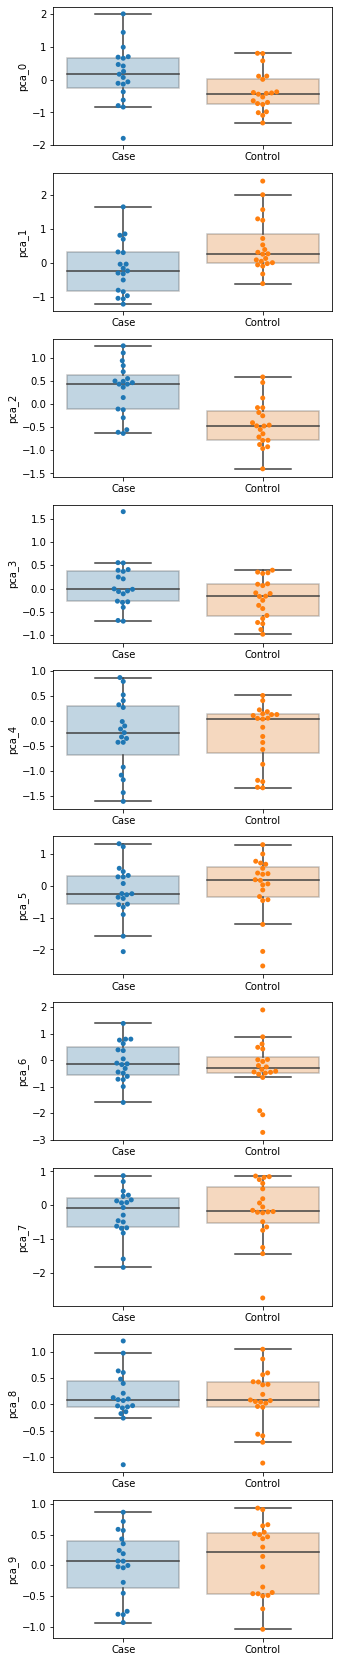

In [439]:
fig, axes = plt.subplots(nrows=10, figsize=(5, 30))

for idx, ax in enumerate(axes):
    sns.swarmplot(x='group', y='pca_{}'.format(idx), hue='group', ax=ax, data=best_pca_features_df)
    sns.boxplot(x='group', y='pca_{}'.format(idx), hue='group', ax=ax, data=best_pca_features_df,
                showfliers=False, dodge=False, boxprops=dict(alpha=.3))
    ax.get_legend().remove()
    ax.set_xticklabels(["Case", "Control"])
    ax.set_xlabel("")

In [391]:
list(columns_1000[index])

['31p_l_wm_supfront_aatp',
 '31p_r_precent_gatp',
 '31p_r_precent_aatp',
 '31p_r_smc_aatp',
 '31p_r_mfg_aatp',
 '31p_r_temppole_aatp',
 '31p_l_mfg_aatp',
 '31p_r_ocp_gatp',
 '31p_l_wm_suptemp_aatp',
 '31p_r_wm_postcent_aatp',
 '31p_r_crbl_cort_aatp',
 '31p_r_suppar_aatp',
 '31p_l_crblcrtx_gatp',
 '31p_l_wm_insula_aatp',
 '31p_r_postcent_gatp',
 '31p_r_wm_parcent_aatp',
 '31p_r_sfg_aatp',
 '31p_r_mog_aatp',
 '31p_r_wm_precent_aatp']

### Logistic Regression

In [440]:
from scipy.special import expit
pipeline2.named_steps['clf'].coef_

array([[-1.23483667,  2.53811006, -1.39940871, -1.41374364,  1.27034861,
         1.88076547, -0.98550745, -0.72363342,  0.75848958,  0.8082933 ]])

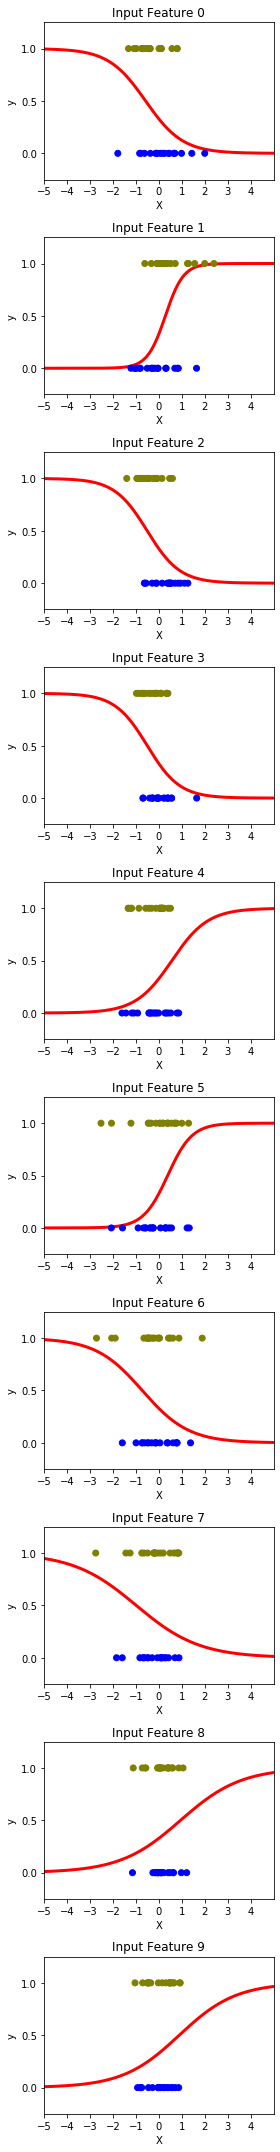

In [442]:
# and plot the result
colors = ['olive' if x == 1 else 'blue' for x in y_best_guess]
fig, axes = plt.subplots(nrows=10, figsize=(4, 30))
for idx, ax in enumerate(axes):
    ax.scatter(x_features_best_pca[:,idx].ravel(), y_best_guess, color=colors, zorder=20)
    X_test = np.linspace(-5, 5, 300)

    loss = expit(X_test * pipeline2.named_steps['clf'].coef_[0][idx] + pipeline2.named_steps['clf'].intercept_).ravel()
    ax.plot(X_test, loss, color='red', linewidth=3)


    ax.set_ylabel('y')
    ax.set_xlabel('X')
    ax.set_xticks(range(-5, 5))
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim(-.25, 1.25)
    ax.set_xlim(-5, 5)
    ax.set_title("Input Feature {}".format(idx))

fig.tight_layout()